In [71]:
import optuna as opt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
#from twilio.rest import Client
import pickle

import time

import sys
import os 


sys.path.append('../../pscapes')
sys.path.append('./')


from torch.utils.data import DataLoader

from pscapes.landscape_class import ProteinLandscape
from pscapes.utils import dict_to_np_array, np_array_to_dict

from architectures import SequenceRegressionCNN, SequenceRegressionLinear, SequenceRegressionMLP, SequenceRegressionLSTM, SequenceRegressionTransformer

from ml_utils import train_val_test_split_ohe, landscapes_ohe_to_numpy
from hyperopt import objective_NK, sklearn_objective_NK

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 

from train_utils import train_models_from_hparams_NK, read_MLP_hparams, read_CNN_hparams

In [72]:
HPARAM_PATH = '../hyperopt/results/NK_hyperopt_results.pkl'
DATA_PATH = '../data/nk_landscapes/'
MODEL_SAVEPATH = '../models/'
RESULT_PATH = '../results/'

In [73]:
SEQ_LEN = 6
AA_ALPHABET  = 'ACDEFG'

In [74]:
with open(HPARAM_PATH, 'rb') as handle: 
    NK_hparams = pickle.load(handle)

In [ ]:
model_names = ['linear', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer', 'RF', 'GB']


In [90]:
for model_name in model_names: 
    for k_val in range(SEQ_LEN): 
        best_val = NK_hparams[model_name][k_val].best_value


In [124]:
opt.study.StudySummary(NK_hparams['mlp'][0].study_name)

TypeError: StudySummary.__init__() missing 7 required positional arguments: 'direction', 'best_trial', 'user_attrs', 'system_attrs', 'n_trials', 'datetime_start', and 'study_id'

In [127]:
NK_hparams['blstm'][0].trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_hidden_size,params_lr,params_num_layers,state
0,0,0.000008,2024-11-05 09:27:50.498713,2024-11-05 09:27:54.641470,0 days 00:00:04.142757,256,256,0.0010,1,COMPLETE
1,1,0.000020,2024-11-05 09:27:54.641846,2024-11-05 09:28:13.577985,0 days 00:00:18.936139,256,64,0.0001,3,COMPLETE
2,2,0.000022,2024-11-05 09:28:13.578395,2024-11-05 09:28:20.287267,0 days 00:00:06.708872,128,128,0.0100,4,COMPLETE
3,3,0.000008,2024-11-05 09:28:20.287658,2024-11-05 09:28:24.090640,0 days 00:00:03.802982,256,512,0.0010,1,COMPLETE
4,4,0.000276,2024-11-05 09:28:24.091036,2024-11-05 09:28:32.103628,0 days 00:00:08.012592,64,64,0.0100,2,COMPLETE
5,5,0.013381,2024-11-05 09:28:32.104028,2024-11-05 09:28:34.156510,0 days 00:00:02.052482,128,512,0.0001,3,PRUNED
6,6,0.013805,2024-11-05 09:28:34.156777,2024-11-05 09:28:37.329001,0 days 00:00:03.172224,32,64,0.0001,4,PRUNED
7,7,0.015082,2024-11-05 09:28:37.329247,2024-11-05 09:28:39.004435,0 days 00:00:01.675188,32,64,0.0001,1,PRUNED
8,8,0.000093,2024-11-05 09:28:39.004708,2024-11-05 09:28:41.338528,0 days 00:00:02.333820,128,256,0.0100,2,PRUNED
9,9,0.024793,2024-11-05 09:28:41.339101,2024-11-05 09:28:41.620812,0 days 00:00:00.281711,256,128,0.0001,1,PRUNED


Text(108.125, 0.5, 'Validation Loss (MSE)')

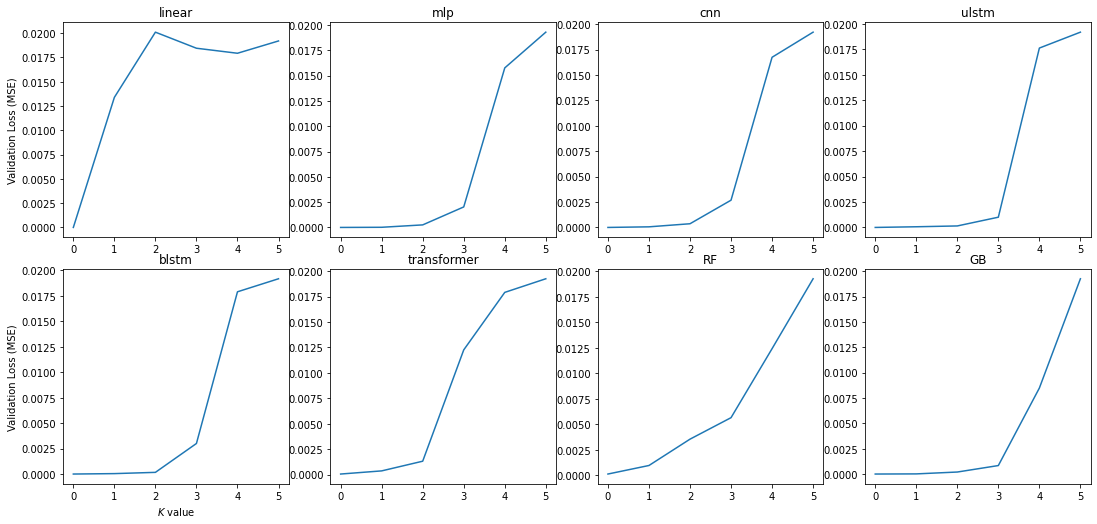

In [98]:
fig,ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
fig.tight_layout()
for index, axis in enumerate(ax.ravel()):
    model_val_losses = [NK_hparams[model_names[index]][k_val].best_value for k_val in range(SEQ_LEN)]
    axis.plot(model_val_losses)
    #axis.set_ylim(-1.5,1.5)
    axis.set_title(model_names[index])
    
ax[0,0].set_ylabel('Validation Loss (MSE)')
ax[1,0].set_xlabel('$K$ value')

ax[1,0].set_ylabel('Validation Loss (MSE)')



In [110]:
y1 = torch.randn(1, 5).ravel()
y2 = torch.randn(1, 5).ravel()

In [117]:
stacked= torch.stack((y1, y2), dim=0)

In [118]:
torch.corrcoef(stacked)

tensor([[ 1.0000, -0.2754],
        [-0.2754,  1.0000]])

In [114]:
y1_np = y1.numpy()
y2_np = y2.numpy()

In [112]:
from scipy.stats import pearsonr

In [113]:
pearsonr(y1, y2)

PearsonRResult(statistic=np.float64(-0.2754175993613899), pvalue=np.float32(0.65381265))

In [115]:
pearsonr(y1_np, y2_np)

PearsonRResult(statistic=np.float64(-0.2754175993613899), pvalue=np.float32(0.65381265))

In [87]:
NK_hparams['transformer'][2].best_value

0.0013195084493495843

In [66]:
with open('../results/NK_train_test_results.pkl', 'rb') as handle: 
    results = pickle.load(handle) 
with open('../results/results2_early_stopping_patience/NK_train_test_results.pkl', 'rb') as handle: 
    new_results = pickle.load(handle) 


In [67]:
def extract_results(results_dict): 
    model_names = ['linear', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer', 'RF', 'GB']
    K_values = range(6)

    results_list = []
    for model_name in model_names: 
        model_r2 = []
        for k_val in K_values: 
            r2 = results_dict[model_name][k_val]['r2']
            model_r2.append(r2)
        results_list.append(model_r2)
    return np.array(results_list)

In [68]:
result_r2_array = extract_results(results)
new_result_r2_array = extract_results(new_results)

In [18]:
import matplotlib.pyplot as plt

In [34]:
HPARAM_PATH

'../hyperopt/results/NK_hyperopt_results.pkl'

In [47]:
def get_latent_rep_MLP(x_data, mlp_model_instance): 
    latent_model = nn.Sequential(*list(model.children())[:-1])
    latent_rep   = latent_model(x_data)
    return latent_rep

def get_latent_rep_CNN(x_data, cnn_model_instance): 
    latent_model = nn.Sequential(*list(model.children())[:-1])
    latent_rep   = latent_model(x_data)
    return latent_rep
    

In [55]:
model_params = read_CNN_hparams(NK_hparams['cnn'][3].best_params)

In [56]:
model_params['input_channels']=6
model_params['sequence_length']=6

In [57]:
model = SequenceRegressionCNN(**model_params)

In [58]:
model.load_state_dict(torch.load('../models/cnn_NK_k3_r0.pt', weights_only=True))

<All keys matched successfully>

In [64]:
latent_model = nn.Sequential(*list(model.children())[:-1])

In [65]:
latent_model

Sequential(
  (0): ModuleList(
    (0): Conv1d(6, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(256, 224, kernel_size=(4,), stride=(1,), padding=(2,))
  )
  (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [19]:
result_r2_array[0]

array([[ 1.00000000e+00],
       [-9.30855192e-01],
       [-1.12348316e+01],
       [-3.86594360e+01],
       [-2.88619342e+02],
       [-9.34203730e+02]])

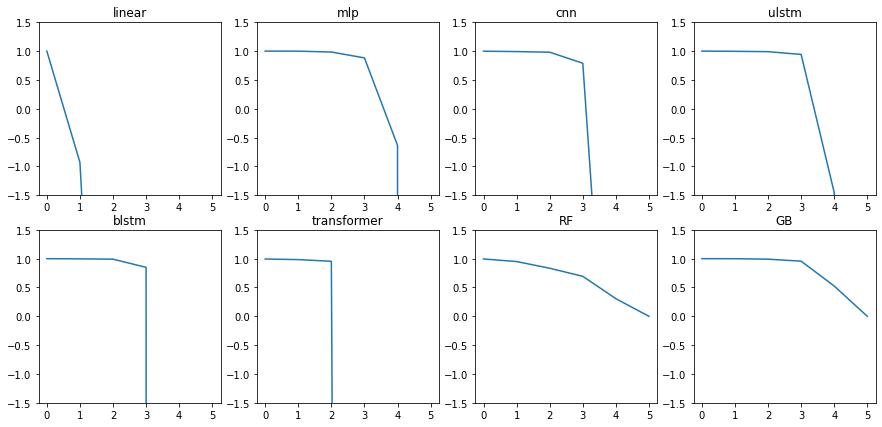

In [26]:
fig,ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
model_names = ['linear', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer', 'RF', 'GB']

for index, axis in enumerate(ax.ravel()):
    axis.plot(result_r2_array[index])
    axis.set_ylim(-1.5,1.5)
    axis.set_title(model_names[index])




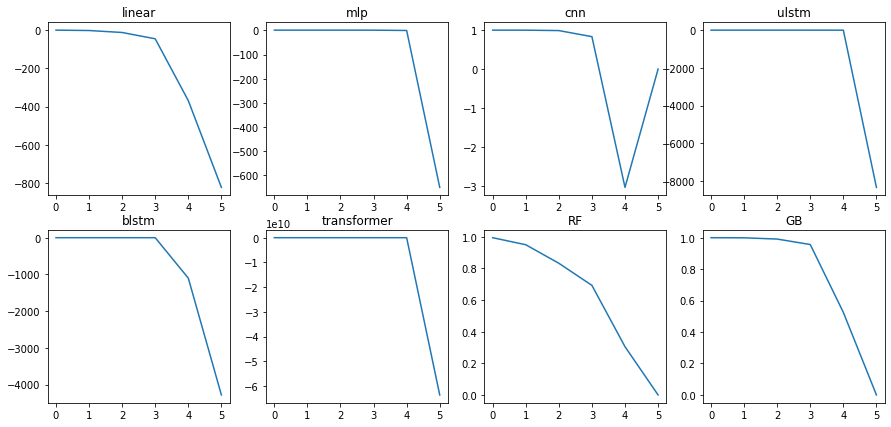

In [70]:
fig,ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
model_names = ['linear', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer', 'RF', 'GB']

for index, axis in enumerate(ax.ravel()):
    axis.plot(new_result_r2_array[index])
    axis.set_title(model_names[index])


In [11]:
means = []
for k_index in results['linear'].keys(): 
    mean_r2 = np.mean(np.array(results['linear'][k_index]['r2']))
    means.append(mean_r2)

In [ ]:
def extract_latent_rep_mlp(x_data, model): 
    

In [13]:
import matplotlib.pyplot as plt

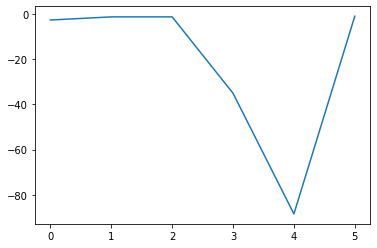

In [14]:
plt.plot(means)

In [7]:
v = {x:None for x in range(4)}

In [10]:
v[0] = 'f'

In [11]:
v

{0: 'f', 1: None, 2: None, 3: None}

In [8]:
for model_name in NK_hparams.keys(): 
    for study in NK_hparams[model_name]: 
        print(study.best_params)

{'lr': 0.0001, 'batch_size': 128}
{'lr': 0.001, 'batch_size': 32}
{'lr': 0.0001, 'batch_size': 32}
{'lr': 0.001, 'batch_size': 128}
{'lr': 0.001, 'batch_size': 128}
{'lr': 0.0001, 'batch_size': 64}
{'lr': 0.001, 'batch_size': 32, 'n_hidden_layers': 1, 'hidden0_size': 256}
{'lr': 0.0001, 'batch_size': 128, 'n_hidden_layers': 2, 'hidden0_size': 256, 'hidden1_size': 64}
{'lr': 0.001, 'batch_size': 64, 'n_hidden_layers': 2, 'hidden0_size': 256, 'hidden1_size': 32}
{'lr': 0.01, 'batch_size': 256, 'n_hidden_layers': 3, 'hidden0_size': 64, 'hidden1_size': 128, 'hidden2_size': 32}
{'lr': 0.001, 'batch_size': 256, 'n_hidden_layers': 3, 'hidden0_size': 256, 'hidden1_size': 128, 'hidden2_size': 64}
{'lr': 0.0001, 'batch_size': 128, 'n_hidden_layers': 3, 'hidden0_size': 64, 'hidden1_size': 256, 'hidden2_size': 64}
{'lr': 0.01, 'batch_size': 256, 'num_conv_layers': 1, 'n_kernels_layer0': 224.0, 'kernel_size_layer0': 3.0}
{'lr': 0.0001, 'batch_size': 64, 'num_conv_layers': 2, 'n_kernels_layer0': 192